<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - Iscte <b>
     </div>
</font> 
 
 
     
    
  <font size="5"> OEOD </font>
  
  
  
  <font size="3"> **Diana Aldea Mendes**, October 2023 </font>
  
   
  <font size="3"> *diana.mendes@iscte-iul.pt* </font> 
  
    
 
  
    
  <font color='blue'><font size="5"> <b>Week 5 - Case study 1 - RL for finance (algorithmic trading)<b></font></font>

# RL for algorithmic trading

- **Main purpose**: define a trading strategy and predict if you buy or sell
- A trading strategy is a systematic methodology used for buying and selling in the securities markets. 
- The Trading strategy is based on predefined rules used to make the trading decisions.
- Usually we define some rule like the following: - We go long (buy the stock) if the %A line goes below x, and the Trend and Signal line are lesser than -y. Similarly, we go short (sell the stock) if the %A line crosses above z, and Trend and Signal are greater than y. 
    
    - End-of-day trading strategy: trade when the price is going to ‘settle’ or close
    - Trend trading strategy: a trader uses *technical analysis* to define a trend, and only enters trades in the direction of the pre-determined trend.
    - Position trading strategy: trader holds a position for a long period of time, usually months or years, ignoring minor price fluctuations in favor of profiting from long-term trends (use *fundamental analysis*)
    - Pairs trading
    - Momentum trading
    - Moving Average (MA) or Exponential Moving Average (EMA)
    - Bollinger band based strategy
 


In [22]:
# import libraries

import yfinance as yf  # import data from web (financial time series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  ## interactive data visualization

# high-quality figures
%config InlineBackend.figure_format = 'svg'


## Import and visualize data

In [23]:

# historical stock price data for QQQ , from the period 2016 to 2022
## QQQ - biggest online retail companies (Amazon, Booking, Costco, Airbnb, eBay, etc)

qqq = yf.Ticker("QQQ")
data = qqq.history(start="2016-01-01", end="2022-12-31")


data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2016-01-04 00:00:00-05:00,103.183169,103.324581,101.929326,103.230309,50807600,0.0,0.0,0.0
2016-01-05 00:00:00-05:00,103.739391,103.871374,102.570392,103.051186,38795200,0.0,0.0,0.0
2016-01-06 00:00:00-05:00,101.259988,102.655243,101.259988,102.061317,41891100,0.0,0.0,0.0
2016-01-07 00:00:00-05:00,99.883574,101.146853,98.808848,98.865417,61386300,0.0,0.0,0.0
2016-01-08 00:00:00-05:00,99.581903,100.204117,97.950962,98.054665,69344000,0.0,0.0,0.0


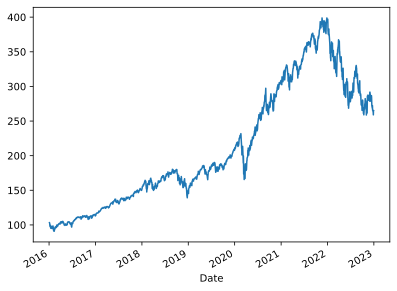

In [24]:
data.Close.plot();

Text(0, 0.5, 'Price in $')

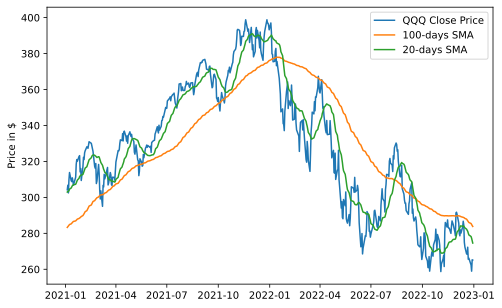

In [25]:
## visualize signal and moving average lines

start_date = '2021-01-01'
end_date = '2022-12-31'

# Calculating the short-window simple moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head(20)

# Calculating the long-window simple moving average
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()


fig, ax = plt.subplots(figsize=(8,5))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'Close'], label='QQQ Close Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'Close'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')


## Define trading strategy and backtesting

- Define a trading strategy: 
    - Buy when the price is above the 50-day moving average 
    - sell otherwise

- To define a *moving average* (that is, smooth the data), we use the 'rolling' function and the window size (10 days, 20 days, 50 days, etc). We compute the mean of the last x values and roll this operations until the end of data. The resulting signal is smoother that the original data (highlight the trend and decrease the volatility)

- When the price time series (signal) crosses the MA time series from below, we will close any existing short position and go long (buy) one unit of the asset.
- When the price time series crosses the MA time series  from above, we will close any existing long position and go short (sell) one unit of the asset.

`` data.rolling(window=20).mean()``

- Backtesting: estimate (define some metrics, measure) the performance of the strategy
- We need:
    - log-returns (pct_change() function)
    - cumulative log-returns
    - variance - volatility
    - Sharpe-ratio: measure the risk adjusted performance of an investment over time
    - Value at Risk

In [26]:
# Define the trading strategy
def trading_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Buy when the price is above the 50-day moving average, sell otherwise
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = np.where(data['Close'] > data['Close'].rolling(window=50).mean(), 1, 0)
    return signals

In [27]:
# Perform backtesting
def backtest(data, signals):
    # Combine the historical data with the trading signals
    df = pd.concat([data, signals], axis=1).dropna()

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate cumulative returns
    df['Cumulative Return'] = (1 + df['Return']).cumprod()

    # Calculate portfolio value
    df['Portfolio Value'] = df['Cumulative Return'] * initial_investment

    # Calculate risk-free rate (assumed to be 0 in this example)
    risk_free_rate = 0

    # Calculate metrics
    num_trading_days = len(df)
    returns = df['Return']
    cumulative_returns = df['Cumulative Return']
    portfolio_value = df['Portfolio Value']
    annual_returns = (cumulative_returns[-1]) ** (252/num_trading_days) - 1
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (annual_returns - risk_free_rate) / volatility
    cagr = (cumulative_returns[-1]) ** (252/num_trading_days) - 1
    # alpha, beta = np.polyfit(returns - risk_free_rate, market_returns - risk_free_rate, deg=1)
    variance = returns.var() * 252
    cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

    return df, sharpe_ratio, cagr, cumulative_returns,  variance, cvar

## Apply defined rules to data

In [28]:
# Define initial investment amount
initial_investment = 10000

# Perform the trading strategy
signals = trading_strategy(data)

# Perform backtesting and calculate metrics
backtest_results, sharpe_ratio, cagr, cumulative_returns,  variance, cvar = backtest(data, signals)

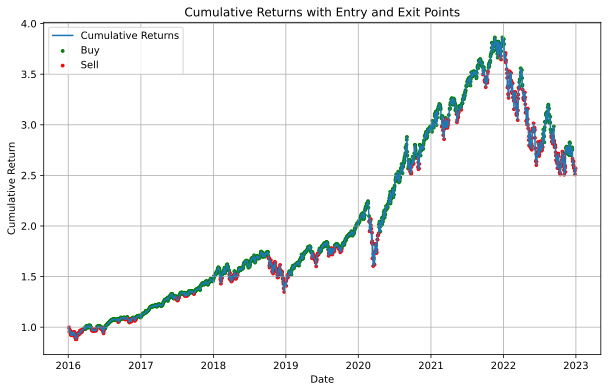

In [29]:
# Plot the cumulative returns with entry and exit points
plt.figure(figsize=(10, 6))
plt.plot(backtest_results.index, cumulative_returns, label='Cumulative Returns')
plt.scatter(backtest_results[backtest_results['Signal'] == 1].index, backtest_results[backtest_results['Signal'] == 1]['Cumulative Return'], color='green', s=8, label='Buy')
plt.scatter(backtest_results[backtest_results['Signal'] == 0].index, backtest_results[backtest_results['Signal'] == 0]['Cumulative Return'], color='red',  s=8, label='Sell')
plt.title('Cumulative Returns with Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Print the calculated metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns[-1]:.2%}")
#print(f"Alpha: {alpha:.4f}")
#print(f"Beta: {beta:.4f}")
print(f"Variance: {variance:.6f}")
print(f"CVaR: {cvar:.6f}")

Sharpe Ratio: 0.62
CAGR: 14.44%
Cumulative Returns: 256.82%
Variance: 0.054194
CVaR: nan


####################################################################

- CAGR - Compound Annual Growth Rate - measures the average annual growth rate of an investment over a given period of time. 
- For example, if you invest 1000 dollars in a stock that has a 10% CAGR, your investment will grow to 1100 dollars after one year, 1210 dollars after two years, and so on.
- The Sharpe ratio is a measure of risk-adjusted return. 
- For example, if an investment has a 10% return and a standard deviation of 5%, the Sharpe ratio would be 2. This means that the investment has a higher return than the benchmark, but with a lower level of risk. The Sharpe ratio is calculated as (R_a-R_b)/σ_a, where R_a is the expected return on the asset, R_b is the return on the risk-free asset, and σ_a is the standard deviation of the asset’s returns


## Q-learning agent

- Environment: the market including historical price data, relevant indicators, and other market factors.
- State: the current market condition of the environment such as price, volume, or market information at a particular time.
- Action: the trading action such as “buy” or “sell”.
- Policy: the objective - such as maximizing returns, minimizing risk, or achieving a specific target.
- Reward: This is the gains in the market.
- The reinforcement learning agent: Develop an agent that learns to make trading decisions based on the observed environment state (Q-learning). 

- Epsilon-greedy policy is a RL algorithm that uses a greedy approach to make decisions. It works by choosing the action that has the highest expected reward.
-  Q-learning update rule: multiply the current Q-value by a learning rate, and add a negative exponential decay term. 

- **Note**: we can incorporate human feedback in reinforcement learning for algorithmic trading - ongoing research area - **RLHF** (*reinforcement learning with human feedback*)

In [31]:
# Define the Q-learning agent
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha, gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        # Q-learning update rule
        max_q_value = np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state, action])

    def choose_action(self, state, epsilon):
        # Epsilon-greedy policy for action selection
        if np.random.uniform() < epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.q_table[state])

In [32]:
# Define the trading strategy with Q-learning and human feedback
def trading_strategy(data, q_agent, entry_points, exit_points, initial_investment):
    num_states = 2  # Number of states (0: out of the market, 1: in the market)
    num_actions = 2  # Number of actions (0: no trade, 1: trade)

    epsilon = 0.1  # Exploration rate
    total_reward = 0  # Track total reward
    portfolio_value = [initial_investment]  # Track portfolio value
    trades = []  # Track executed trades

    # Iterate over each trading day
    for i in range(len(data) - 1):
        state = 0 if portfolio_value[-1] == 0 else 1  # Current state

        # Check if an entry point exists for the current day
        if data.index[i] in entry_points:
            # Get the recommended action for the current day from human feedback
            action = entry_points[data.index[i]]

            # Execute the recommended action
            if action == 'BUY' and state == 0:
                state = 1  # Enter the market
                shares = portfolio_value[-1] / data['Close'][i]  # Buy as many shares as possible
                trades.append(('BUY', data.index[i], data['Close'][i], shares))
            elif action == 'SELL' and state == 1:
                state = 0  # Exit the market
                shares = portfolio_value[-1] / data['Close'][i]  # Sell all shares
                trades.append(('SELL', data.index[i], data['Close'][i], shares))

        # Calculate the reward based on the portfolio value change
        reward = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2] if i > 0 else 0
        total_reward += reward

        # Choose the action using epsilon-greedy policy
        action = q_agent.choose_action(state, epsilon)

        # Execute the action
        if action == 1 and state == 0:
            state = 1  # Enter the market
            shares = portfolio_value[-1] / data['Close'][i]  # Buy as many shares as possible
            trades.append(('BUY', data.index[i], data['Close'][i], shares))
        elif action == 0 and state == 1:
            state = 0  # Exit the market
            shares = portfolio_value[-1] / data['Close'][i]  # Sell all shares
            trades.append(('SELL', data.index[i], data['Close'][i], shares))

        # Update the Q-table
        next_state = 0 if state == 0 else 1  # Next state
        q_agent.update_q_table(state, action, reward, next_state)

        # Update the portfolio value
        portfolio_value.append(shares * data['Close'][i])

    return total_reward, portfolio_value, trades

In [33]:
# Define the entry and exit points (example)
entry_points = {
    '2018-04-01': 'BUY',
    '2018-05-01': 'SELL',
    '2018-08-01': 'BUY',
    '2018-09-01': 'SELL'
}

exit_points = {
    '2018-05-01': 'SELL',
    '2018-06-01': 'BUY',
    '2018-09-01': 'SELL',
    '2018-10-01': 'BUY'
}

# Set the initial investment
initial_investment = 10000

# Create the Q-learning agent
q_agent = QLearningAgent(num_states=2, num_actions=2, alpha=0.2, gamma=0.9)

# Apply the trading strategy
total_reward, portfolio_value, trades = trading_strategy(data, q_agent, entry_points, exit_points, initial_investment)


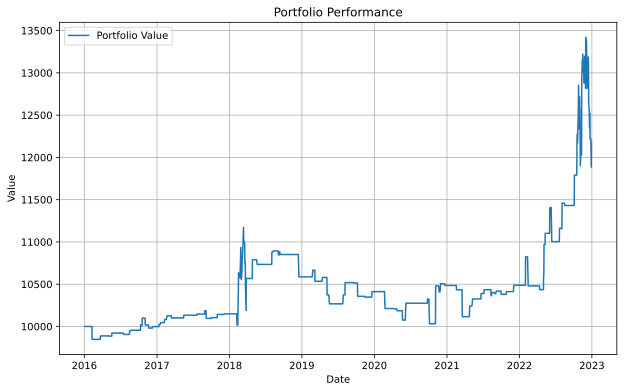

In [34]:
# Calculate metrics
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
cagr = (portfolio_value[-1] / portfolio_value[0]) ** (252 / len(data)) - 1
cumulative_returns = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0]
variance = np.var(returns)
cvar = np.mean(returns[returns < np.percentile(returns, 5)])
alpha, beta = np.polyfit(data['Close'].pct_change().dropna(), returns, deg=1)

# Plot portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(data.index, portfolio_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Print metrics
print('Metrics:')
print(f'Sharpe Ratio: {sharpe_ratio:.3f}')
print(f'CAGR: {cagr:.3f}')
print(f'Cumulative Returns: {cumulative_returns:.3f}')
print(f'Variance: {variance:.6f}')
print(f'CVaR (Conditional Value at Risk): {cvar:.6f}')
print(f'Alpha: {alpha:.6f}')
print(f'Beta: {beta:.6f}')
print(f'portfolio_value: {portfolio_value[-1]:.6f}')

Metrics:
Sharpe Ratio: 0.400
CAGR: 0.029
Cumulative Returns: 0.217
Variance: 0.000024
CVaR (Conditional Value at Risk): -0.009629
Alpha: 0.001378
Beta: 0.000123
portfolio_value: 12174.705568


In [36]:
teste

NameError: name 'teste' is not defined